In [1]:
# Setting up the Colab environment. DO NOT EDIT!
try:
  from applied_biostats import setup_environment
except ImportError:
  !pip -q install applied-biostats-helper
  from applied_biostats import setup_environment
finally:
  grader = setup_environment('Module10_walkthrough')

# Walkthrough

## Learning Objectives
At the end of this learning activity you will be able to:
 - Describe a generic strategy for power calculations.
 - Define the terms `effect_size`, `alpha`, and `power`.
 - Describe the trade-off of `effect_size`, `alpha`, `power`, and `sample_size`.
 - Calculate the fourth value given the other three.
 - Interpret a power-plot of multiple experimental choices.
 - Rigorously choose the appropriate experimental design for the best chance of success.

For this last week, we are going to look at experimental design.
In particular, sample size calculations.

As a test-case we will imagine that we are helping Dr. Kortagere evaluate a new formulation of her SK609 compound.
It is a selective dopamine receptor activator that has been shown to improve attention in animal models.
You can review her paper [**Selective activation of Dopamine D3 receptors and Norepinephrine Transporter blockade enhance sustained attention**](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6424628/)
on pubmed.
We'll be reviewing snippets through the assignment.

As part of this new testing we will have to evaluate her new formulation in the same animal model.
In this assignment we are going to determine an appropriate sample size.



## A Power Analysis in 6 steps

As the "biostats guy" most people know, I'm often the first person someone comes to looking for this answer.
So, over the years I've developed a bit of a script.
It is part art, part math, and relies on domain knowledge and assumptions.

Before you can determine a sample size you need to devise a *specific*, **quantitative**, and **TESTABLE** hypothesis.
Over the past few weeks we've covered the main ones:
 - Linked categories - chi2 test
 - Difference in means - t-test
 - Regression-based analysis

With enough Googling you can find a calculator for almost any type of test, and simulation strategies can be used to estimate weird or complex tests if needed.

During the signal trials, animals were trained to press a lever in response to a stimulus, which was a cue light. During the non-signal trials, the animals were trained to press the opposite lever in the absence of a cue light. [Methods]
Over a 45 minute attention assay cued at psueodorandom times, their success in this task was quantified as a Vigilance Index (VI), with larger numbers indicating improved attention.

Figure 1 shows the design.

![Figure 1](https://cdn.ncbi.nlm.nih.gov/pmc/blobs/7ad9/6424628/c5af74734da6/nihms-1006809-f0001.jpg)

Our hypothesis is that this new formulation increases the vigilance index relative to vehicle treated animals.

## Step 2: Define success

Next, we need to find the `effect_size`.
Different tests calculate this differently, but it always means the same thing: 
**the degree of change divided by the noise in the measurement.**

These are things that rely on domain knowledge of the problem.
The amount of change should be as close to something that is clinically meaningful.
The amount of noise in the measurement is defined by your problem and your experimental setup.

If you have access to raw data, it is ideal to calculate the difference in means and the standard deviations exactly.
But often, you don't have that data.
For this exercise I'll teach you how to find and estimate it.

In this simple example, we'll imagine replicating the analysis considered in [Figure 3B](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6424628/figure/F3/).

![Figure 3](https://cdn.ncbi.nlm.nih.gov/pmc/blobs/7ad9/6424628/98810d3bec35/nihms-1006809-f0003.jpg)

We'll start with B. This compares the effect of SK609 VI vs a vehicle control. Parsing through the figure caption we come to:

```
(B) Paired t-test indicated that 4 mg/kg SK609 significantly increased sustained attention performance as measured by average VI score relative to vehicle treatment (t(7)=3.1, p = 0.017; 95% CI[0.14, 0.19]).
```

This was a *paired* t-test, since it is measuring the difference between vehicle and SK609 in the same animal. The p=0.017 tells use this difference is unlikely due to chance and the CI tells us that the difference in VI between control and SK609 is between 0.14 and 0.19.

If we're testing a new formulation of SK609 we know we need to be able to detect a difference as low as 0.14. We should get a VI of ~0.8 for control and ~0.95 for SK609. If the difference is smaller than this, it probably isn't worth the switch.

Therefore we'll define success as:
```
SK609a will increase the VI of an animal by at least 0.14 units. 
```

In [2]:
min_change = 0.14

Then we need an estimate of the error in the measurement.
In an ideal world, we would calculate the standard deviation.
But I don't have that. 
So, I'll make an assumption that we'll adjust as we go.

I like to consider two pieces of evidence when I need to guess like this.
First, looking at the figure above, the error bars. 
From my vision they look to be about ~0.02-0.04 units.
Or, if we considered a ~20% measurement error 0.8 x 0.2 = 0.16.
So, an estimate of 0.08 error would seem *reasonable*.

In [3]:
error = 0.08

Our estimate of the `effect_size` is the ratio of the change and the error.

In [4]:
effect_size = min_change/error
print('Effect Size', effect_size)

Effect Size 1.7500000000000002


You'll notice that the `effect_size` is unit-less and similar to a z-scale.

## Step 3: Define your tolerance for risk

When doing an experiment we consider two types of failures.
 - False Positives - Detecting a difference when there truly isn't one - `alpha` 
 - False Negatives - Not detecting a true difference - `power`
 
We've been mostly considering rejecting false-positives (p<0.05).
The power of a test is the converse.
It is the likelihood of detecting a difference if there truly is one.
A traditional cutoff is `>0.8`; implying there is an 80% chance of detecting an effect if there truly is one.

## Step 4: Define a budget

You need to have _some_ idea on the scale and cost of the proposed experiment.
How much for 2 samples, 20 samples, 50 samples, 200 samples.

This will be an exercise in trade-offs you need to have reasonable estimates of how much you are trading off.
This is where you should also consider things like sample dropouts. outlier rates, and other considerations.

In [5]:
# In each group
exp_nobs = [2, 4, 8, 10]

## Step 5: Calculate

With our 4 pieces of information:
 - effect_size
 - power
 - alpha
 - nobs
 
We can start calculating. 
A power analysis is like a balancing an __X__ with 4 different weights at each point.
At any time, 3 of the weights are fixed and we can use a calculator to determine the appropriate weight of the fourth.

Our goal is to estimate the cost and likely success of a range of different experiment choices.
Considering that we have made a _lot_ of assumptions and so we should consider noise in our estimate.

Each type of test has a different calculator that can perform this 4-way balance.

We'll use the `pingouin` Python library to do this (https://pingouin-stats.org/build/html/api.html#power-analysis).
However, a simple Google search for: "statistical power calculator" will also find similar online tools for quick checks.
Try to look for one that "draws" as well as calculates.

In [6]:
import numpy as np
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt

All Python power calculators I've seen work the same way.
They accept 4 parameters, one of which, must be `None`.
The tool will then use the other 3 parameters to estimate the 4th.

In [7]:
min_change = 0.14
error = 0.08

effect_size = min_change/error

power = 0.8
alpha = 0.05

pg.power_ttest(d = effect_size,
               n = None,
               power = power,
               alpha = alpha,
               contrast = 'paired',
               alternative = 'greater')

3.7683525901861725

So, in order to have an 80% likelihood of detecting an effect of 0.14 (or more) at a p<0.05 we need at least 4 animals in each group.

### Q1: Calculate the power if there are only two animals in each group.

| **Total Points** | 5 |
|--------|----|
| Included Checks | 1 |

_Points:_ 5

In [8]:
# BEGIN SOLUTION NO PROMPT

q1p = pg.power_ttest(d = effect_size,
                     n = 2,
                     power = None,
                     alpha = alpha,
                     contrast = 'paired',
                     alternative = 'greater')
# END SOLUTION

q1_power = q1p # SOLUTION

print(f'With two animals per group. The likelihood of detecting an effect drops to {q1_power*100:0.0f}%')

With two animals per group. The likelihood of detecting an effect drops to 30%


In [ ]:
grader.check("q1_twosample_power")

What if we're worried this formulation only has a small effect or a highly noisy measurement. So, we've prepared 12 animals, what is the smallest difference we can detect? Assuming the same 80% power and 0.05 alpha.

### Q2: Calculate the smallest effect size if there are 12 animals in each group.

| **Total Points** | 5 |
|--------|----|
| Included Checks | 1 |

_Points:_ 5

In [10]:
# BEGIN SOLUTION NO PROMPT

q2e = pg.power_ttest(n = 12,
                     power = power,
                     alpha = alpha,
                     contrast = 'paired',
                     alternative = 'greater')
# END SOLUTION

q2_effect = q2e # SOLUTION

print(f'With 12 animals per group. You can detect an effect {effect_size/q2_effect:0.3f}X smaller than the minimum effect.')

With 12 animals per group. You can detect an effect 2.283X smaller than the minimum effect.


In [ ]:
grader.check("q2_12sample_effect")

The solver method is great when you have a specific calculation.
But it doesn't tell you much beyond a cold number with little context.
How does it change as we make different assumptions about our effect size or our budget?

## Step 6: Summarize

Let's "propose" a number of different experiments different experiments.
We'll keep the power and alpha the same but consider different group sizes 2, 4, 6, 10, and 15 each.
How do these choices impact our ability to detect different effect sizes?
We'll also assume our true effect size could be 2X too high or 2X too low.

In [12]:
# I find the whitegrid style to be the best for this type of visualization
sns.set_style('whitegrid')

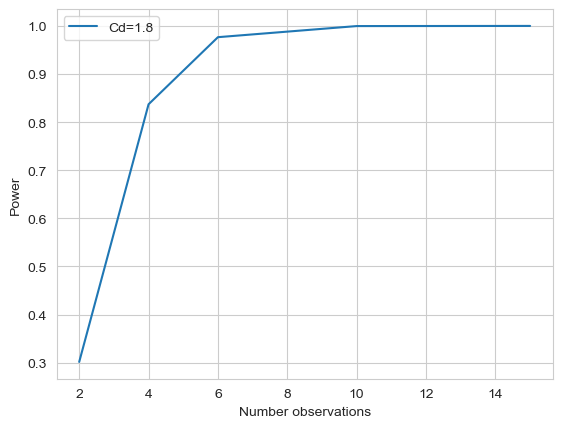

In [13]:
# How many animals in each proposed experiment
nobs_sizes = np.array([2, 4, 6, 10, 15])

# power_ttest accepts arrays in any parameter
calced_power = pg.power_ttest(n = nobs_sizes,
                              d = effect_size,
                              power = None,
                              alpha = alpha,
                              contrast = 'paired',
                              alternative = 'greater')

# Then I can plot the power vs the number of animals
plt.plot(nobs_sizes, calced_power, label = f'Cd={effect_size:0.1f}')
plt.ylabel('Power')
plt.xlabel('Number observations')
plt.legend()

Since we can plot multiple assumptions on the same graph, we can make complex reasonings about our experimental design.

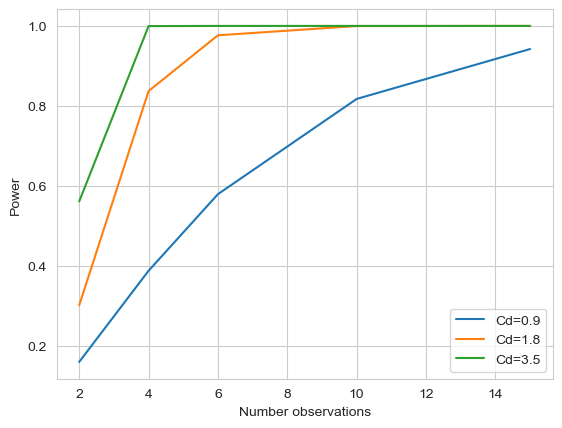

In [14]:
# Pick multiple different assumptions about the effect-size
effect_sizes = [effect_size/2, effect_size, effect_size*2]

nobs_sizes = np.array([2, 4, 6, 10, 15])

for ef in effect_sizes:
    calced_power = pg.power_ttest(n = nobs_sizes,
                                  d = ef,
                                  power = None,
                                  alpha = alpha,
                                  contrast = 'paired',
                                  alternative = 'greater')

    plt.plot(nobs_sizes, calced_power, label = f'Cd={ef:0.1f}')

plt.ylabel('Power')
plt.xlabel('Number observations')
plt.legend()

With this graph we can make some decisions with better knowledge about the context.

If we're confident our effect size estimate is correct or an 'under-estimate', then we should do 4-6 animals.
This will give us a >80% chance of finding an effect if it truly exists.
However, if we have any doubt that our estimate may be high, then we see that 4-6 animals would put us in the 50:50 range.
Then maybe it is better to spend the money for ~10 animals to obtain a high degree of confidence in a worst-case scenario.

## The other use of Power Tests

T-tests estimate whether there is a difference between two populations.
However, a p>0.05 **does not mean the two distributions are the same**.
It means that either they are the same **or** you did not have enough *power* to detect a difference this small.
If we want to measure whether two distributions are statistically "the same" we need a different test.

Enter, the **TOST**, Two one-sided test for _equivelence_.

This test is more algorithm than equation.
Here is the basic idea:

 - Specify the Equivalence Margin (`bound`): Before conducting the test, researchers must define an equivalence margin, which is the maximum difference between the treatments that can be considered practically equivalent. This margin should be determined based on clinical or practical relevance.
 - Conduct Two One-Sided Tests: TOST involves conducting two one-sided t-tests:
   - The first test checks if the upper confidence limit of the difference between treatments is less than the positive equivalence margin.
   - The second test verifies that the lower confidence limit is greater than the negative equivalence margin.
 - Interpret the Results: Equivalence is concluded if both one-sided tests reject their respective null hypotheses at a predetermined significance level.

This means that the confidence interval for the difference between treatments lies entirely within the equivalence margin.
Thus, they are the *same*.

Imagine we were testing two different batches and wanted to ensure there was no difference between them.
A meaninful difference would be anything above 5% in the VI.

Text(0, 0.5, 'VI')

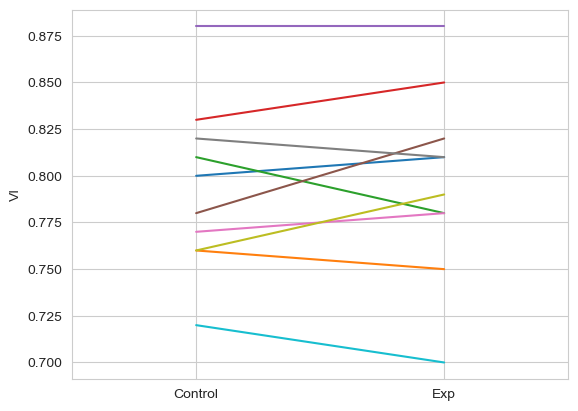

In [15]:
hyp_batchA_res = np.array([0.80, 0.76, 0.81, 0.83, 0.88, 0.78, 0.77, 0.82, 0.76, 0.72])
hyp_batchB_res = np.array([0.81, 0.75, 0.78, 0.85, 0.88, 0.82, 0.78, 0.81, 0.79, 0.70])

fig, ax = plt.subplots(1,1)
for ctl, sk in zip(hyp_batchA_res, hyp_batchB_res):
    ax.plot([1, 2], [ctl, sk])
ax.set_xlim(.5, 2.5)
ax.set_xticks([1, 2])
ax.set_xticklabels(['Control', 'Exp'])
ax.set_ylabel('VI')

Perform a t-test, just to see what happens.

In [16]:
pg.ttest(hyp_batchA_res, hyp_batchB_res, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.569495,9,two-sided,0.582953,"[-0.02, 0.01]",0.083791,0.354,0.056513


As expected, we cannot reject the hypothesis that they are the same.
But this doesn't mean they are the same, just that they are _not different_.

Now, for the TOST.

In [17]:
bound = 0.05 # Should be in same units as the input

pg.tost(hyp_batchA_res, hyp_batchB_res, 0.05, paired=True)

,bound,dof,pval
TOST,0.05,9,0.000053


So, if we use a bound of 5% VI, then the likelihood that there is a difference **5% or larger** is `0.000053`.
Therefore we can statistically say that they are the same _within this bound_.

---------------------------------------------

## Submission

You do not need to submit this walkthrough notebook.
Simply complete the quiz.

In [18]:
grader.check_all()